<a href="https://colab.research.google.com/github/JennEYoon/deep-learning/blob/main/chollet2/chollet_chp10_timeseries2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was generated for TensorFlow 2.6.

Jennifer Yoon, run on Colab and local wsl2.  
Feb 2022, 2/28/2022 update on Colab.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-02-28 22:51:45--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.132.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.132.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  57.6MB/s    in 0.2s    

2022-02-28 22:51:46 (57.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
# 420,450 data rows, 1 header row 
# first row date 1/1/2009 time 00:10:00
# last row 1/1/2017 00:00:00
# day, month, year, time hh:mm:ss format.  
# sampled every 10 minutes, seconds are always 00.  

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
# data inspection with pandas  
import pandas as pd  
print("Pandas", pd.__version__)
!python --version

In [ ]:
jena = pd.read_csv(fname)
print(jena.head())
print(jena.tail())
print(len(jena))

In [ ]:
jena.iloc[420450, 0]

In [ ]:
jena.iloc[420450, :]

In [ ]:
jena.describe()

In [ ]:
jena.corr()

In [ ]:
df = jena.iloc[:, [0, 2, 4, 5, 7]]
df.head()

In [ ]:
df1 = df[1, :]
df2 = (df1-df1.mean())/df1.std()
df2.head()
# guassian normalized, mean 0, std 1.  

In [ ]:
df3 = (df-df.min())/(df.max()-df.min())
df3.head()
# normalized to uniform distribution, range 0 to 1.  

,T (degC),Tdew (degC),rh (%),VPact (mbar)
0,0.248632,0.334788,0.923033,0.084272
1,0.242163,0.326891,0.924182,0.081003
2,0.240504,0.326268,0.929925,0.080639
3,0.243822,0.331255,0.933372,0.082819
4,0.244485,0.331879,0.932223,0.083182


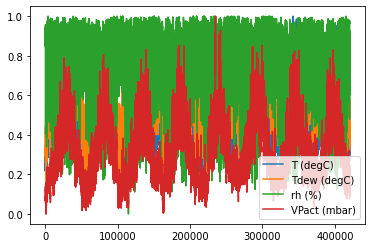

In [ ]:
# plot some relationships.  Temperature seems related to 
# rh, relative humidity, and VPact, pressure actual?  
import matplotlib.pyplot as plt

df3.plot()

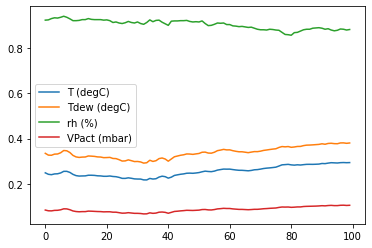

In [ ]:
df4 = df3.iloc[0:100]
df4
df4.plot()

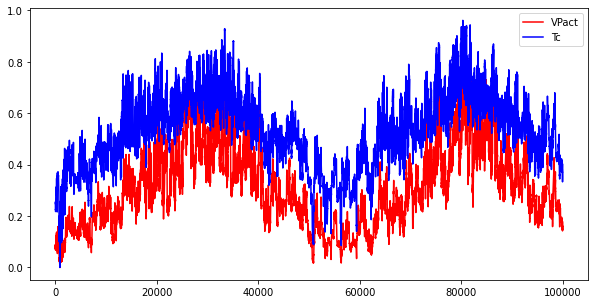

In [ ]:
df5 = df3.iloc[0:100000]
df5.columns = ['Tc', 'Tdew', 'rh', 'VPact']

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

df5.plot(kind='line', y='VPact', color='red', ax=ax)
df5.plot(kind='line', y='Tc', color='blue', ax=ax)
plt.show()

**Parsing the data**  
Back to book

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
np.set_printoptions(precision=3, suppress=True)
print(raw_data[0])

[ 996.52   -8.02  265.4    -8.9    93.3     3.33    3.11    0.22    1.94
    3.12 1307.75    1.03    1.75  152.3 ]


In [5]:
print(raw_data[-1])

[ 999.82   -4.82  268.36   -8.42   75.7     4.27    3.23    1.04    2.01
    3.23 1296.38    1.23    1.96  184.9 ]


In [6]:
# 144 points per day.  
# Summer, 183 days x 144, Noon 12 *6 = 72. 26,424  
print(raw_data[26424])

[ 986.91   24.94  299.23   16.38   59.03   31.61   18.66   12.95   11.85
   18.91 1145.06    3.41    6.25   25.25]


**Plotting the temperature timeseries**

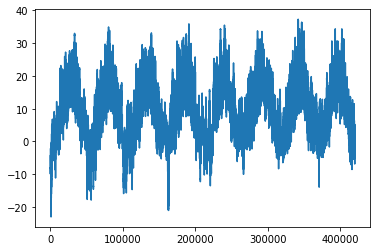

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

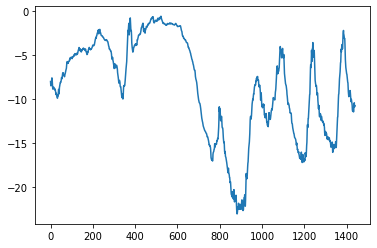

In [8]:
plt.plot(range(1440), temperature[:1440])

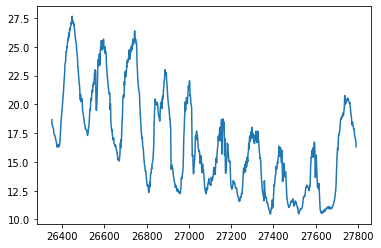

In [11]:
# 26352 Summer, 1st year.  
i = 26352

plt.plot(range(i, i+1440), temperature[i:i+1440])
# ten peaks clearly visible.  

**Computing the number of samples we'll use for each data split**

In [12]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [13]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [14]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [15]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [16]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [17]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 50ms/step - loss: 12.2573 - mae: 2.7147 - val_loss: 10.6065 - val_mae: 2.5761
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9886 - mae: 2.3595 - val_loss: 10.1073 - val_mae: 2.5004
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 8.2871 - mae: 2.2667 - val_loss: 10.4426 - val_mae: 2.5526
Epoch 4/10
819/819 [==============================] - 42s 52ms/step - loss: 7.8447 - mae: 2.2070 - val_loss: 11.5349 - val_mae: 2.6946
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 7.5459 - mae: 2.1628 - val_loss: 12.6181 - val_mae: 2.8132
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 7.2936 - mae: 2.1254 - val_loss: 10.4134 - val_mae: 2.5494
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 7.0710 - mae: 2.0926 - val_loss: 11.4811 - val_mae: 2.6868
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

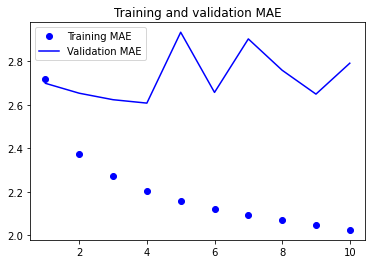

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 51ms/step - loss: 23.1273 - mae: 3.7091 - val_loss: 18.1833 - val_mae: 3.4032
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 15.2723 - mae: 3.0975 - val_loss: 16.4407 - val_mae: 3.1559
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 14.1100 - mae: 2.9755 - val_loss: 13.9052 - val_mae: 2.9538
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 13.2307 - mae: 2.8772 - val_loss: 14.2448 - val_mae: 3.0004
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 12.5884 - mae: 2.8018 - val_loss: 14.5509 - val_mae: 2.9916
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 12.0534 - mae: 2.7430 - val_loss: 14.2911 - val_mae: 2.9857
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 11.5949 - mae: 2.6903 - val_loss: 14.8805 - val_mae: 3.0525


### A first recurrent baseline

**A simple LSTM-based model**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 58ms/step - loss: 41.6874 - mae: 4.6951 - val_loss: 12.5427 - val_mae: 2.6898
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 11.2706 - mae: 2.6048 - val_loss: 9.6914 - val_mae: 2.4275
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 10.0045 - mae: 2.4650 - val_loss: 9.7223 - val_mae: 2.4286
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 9.5479 - mae: 2.4060 - val_loss: 9.7011 - val_mae: 2.4220
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 9.2740 - mae: 2.3728 - val_loss: 9.6847 - val_mae: 2.4177
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 8.9906 - mae: 2.3380 - val_loss: 9.7863 - val_mae: 2.4289
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 8.7909 - mae: 2.3085 - val_loss: 9.7973 - val_mae: 2.4289
Epoch 8/10
819/819 [==============================] - 46s 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [20]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [21]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [24]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 349s 423ms/step - loss: 25.9899 - mae: 3.7830 - val_loss: 10.2497 - val_mae: 2.4790
Epoch 2/50
819/819 [==============================] - 346s 422ms/step - loss: 14.8782 - mae: 2.9995 - val_loss: 9.8964 - val_mae: 2.4347
Epoch 3/50
819/819 [==============================] - 345s 421ms/step - loss: 14.0930 - mae: 2.9124 - val_loss: 9.4416 - val_mae: 2.3816
Epoch 4/50
819/819 [==============================] - 342s 417ms/step - loss: 13.6577 - mae: 2.8665 - val_loss: 9.5890 - val_mae: 2.4022
Epoch 5/50
819/819 [==============================] - 342s 417ms/step - loss: 13.1645 - mae: 2.8178 - val_loss: 9.8814 - val_mae: 2.4372
Epoch 6/50
819/819 [==============================] - 340s 415ms/step - loss: 12.7241 - mae: 2.7687 - val_loss: 9.7074 - val_mae: 2.4179
Epoch 7/50
819/819 [==============================] - 338s 412ms/step - loss: 12.3829 - mae: 2.7332 - val_loss: 9.6897 - val_mae: 2.4197
Epoch 8/50
819/819 [====================

KeyboardInterrupt: ignored

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary